## $k$-Nearest Neighbors (KNN) Algorithm for Anomaly Detection (AD)

The goal of this notebook is to provide a general implementation of the $k$-nearest neighbors (KNN) algorithm as it pertains to the problem of anomaly detection.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import minmax_scale

## KNN for AD Implementation

The following class represents a KNN classifier for pointwise anomaly detection. Methods are provided for obtaining the $k$-nearest neighbors of a given set of points, predicting whether points are anomalous or normal, calculating the anomaly scores for points, and evaluating statistical metrics (accuracy, precision, and recall) of the KNN algorithm's performance on a set of points. The

In the following implementation, the distance metric is the standard Euclidean distance, and the anomaly score is the average $k$-nearest neighbor score (the average distance of the $k$ nearest neighbors of a given data point $X_i$, not including itself).

In [127]:
class KNN:
    """ Represents a k nearest neighbors classifier for pointwise anomaly
        detection.

        Fields: 
            self.n_neighbors (int):
                The number of neighbors to use when classifying points as
                anomalous or normal, or when obtaining the anomaly scores of
                points.
            self.X (ndarray of shape (n_samples, n_features)):
                The training data, or training points.
            self.y (ndarray of shape (n_samples,)):
                The labels corresponding to the training points in X.
    """
    
    def __init__(self, n_neighbors=5):
        """ Initializes a KNN classifier object

        Args:
            n_neighbors (int, optional):
                The number of neighbors to use during classfication. If not an
                integer or greater than 0, n_neighbors is set to 5. Defaults to
                5.
        """
        if isinstance(n_neighbors, int) and n_neighbors > 0:
            self.n_neighbors = n_neighbors
        else:
            self.n_neighbors = 5
        self.X = None
        self.y = None

    def fit(self, X, y=None):
        """ Fits the model to a set of points (X) and an optional set of
            corresponding labels (y).

        Args:
            X (ndarray of shape (n_samples, n_features)):
                The training data, or training points.
            y (ndarray of shape (n_samples,), optional):
                The labels corresponding to the training points in X. Defaults
                to None.

        Returns:
            self (KNN): The fitted classifier.
        """
        self.n_neighbors = min(self.n_neighbors, X.shape[0])
        self.X = X
        self.y = y

        return self

    def kneighbors(self, X=None, n_neighbors=None):
        """ Finds the k nearest neighbors of the points in X, where k is equal
            to n_neighbors (if specified) or self.n_neighbors if not specified.
            
        Args:
            X (ndarray of shape (n_queries, n_features), optional):
                The points from which to find the k nearest neighbors of. If not
                specified, this function finds the k nearest neighbors of each
                point in self.X (not including itself). Defaults to None. 
            n_neighbors (int, optional):
                The number of neighbors to find for each point in X. If not
                specified, self.n_neighbors is used instead. If n_neighbors is
                less than 1, the value 1 is used instead. If n_neighbors is
                greater than the number of points in self.X, all neighbors of
                each point in X are returned. Defaults to None.

        Raises:
            TypeError:
                If self.X is None (in other words, if the model has not been
                fit), an exception is raised.

        Returns:
            distances (ndarray of shape (n_queries, n_neighbors)):
                The distances of the k-nearest neighbors of each of the points
                in X, in sorted order (closest points first).
            indices (ndarray of shape (n_queries, n_neighbors)): 
                The indices of the k-nearest neighbors in self.X of each of the
                points in X, in sorted order (closest points first).
        """
        if self.X is None:
            raise TypeError('Model must be fit before neighbors can be ' +
                            'identified (self.X cannot be None).')
        
        # If X is None, self.X will be used instead
        X_queries = self.X if X is None else X

        # Ensure proper value of n_neighbors
        if n_neighbors is None:
            n_neighbors = self.n_neighbors
        if X is None:
            # If X is None, the maximum of n_neighbors is one less than
            # self.X.shape[0], since the distance to the same point itself is
            # not considered.
            n_neighbors = min(max(1, n_neighbors), self.X.shape[0] - 1)
        else:
            n_neighbors = min(max(1, n_neighbors), self.X.shape[0])

        indices   = np.empty((X_queries.shape[0], n_neighbors))
        distances = np.empty((X_queries.shape[0], n_neighbors))
        for i, X_i in enumerate(X_queries):
            indices_and_distances = [(j, np.linalg.norm(X_i - X_j))
                                     for j, X_j in enumerate(self.X)]
            # Sort list of tuples by distance
            indices_and_distances.sort(key=lambda pair: pair[1])
            # Extract k_nearest neighbors (excluding same point if X is None)
            k_nearest = indices_and_distances[:n_neighbors] if X is not None \
                            else indices_and_distances[1:n_neighbors + 1]

            # Set proper values in indices and distances
            for j, index_and_distance in enumerate(k_nearest):
                indices[i, j] = index_and_distance[0]
                distances[i, j] = index_and_distance[1]

        return distances, indices

    def predict(self, threshold, X=None):
        """ Classifies the points in X as normal (0) or anomalous (1) according
            to the provided threshold. If X is None, predictions are made for 
            all training examples (self.X).

        Args:
            threshold (float):
                The classification threshold that distinguishes
                anomalies from normal points. Corresponds to the maximum average
                Euclidean distance for the k nearest neighbors of a point for
                that point to be considered normal.
            X (ndarray of shape (n_queries, n_features), optional):
                The points to classify as normal or anomalous. If X is None, 
                predictions are made for all training examples (self.X).
                Defaults to None.

        Returns:
            y (ndarray of shape (n_queries,)):
                The predicted labels for each point in X. 1 corresponds to
                anomalous points, and 0 corresponds to normal points.
        """
        distances, _ = self.kneighbors(X=X)
        y = np.empty((distances.shape[0]))
        for i, distance in enumerate(distances):
            y[i] = 1 if distance.mean() > threshold else 0
        return y

    def predict_anomaly_scores(self, X=None):
        """ Calculates the anomaly scores of each point in X. The anomaly score
            of a point is defined as the average distance of the k nearest
            neighbors of that point. If X is None, anomaly scores are obtained
            for all training examples (self.X).

        Args:
            X (ndarray of shape (n_queries, n_features), optional):
                The points for which anomaly scores will be calculated. If X is
                None, anomaly scores are calculated for all training examples
                (self.X). Defaults to None.

        Returns:
            anomaly_scores (ndarray of shape (n_queries,)):
                The anomaly scores corresponding to each point in X.
        """
        distances, _ = self.kneighbors(X=X)
        anomaly_scores = np.empty(distances.shape[0])
        for i, distance in enumerate(distances):
            anomaly_scores[i] = distance.mean()
        return anomaly_scores

    def predict_proba(self, X=None):
        """ Calculates the "probability" of each point in X being an anomaly.
            The "probability" is simply defined as the normalized version of the
            anomaly score array.

        Args:
            X (ndarray of shape (n_queries, n_features), optional):
                The points for which "probabilities" will be calculated. If X is
                None, "probabilities" are calculated for all training examples
                (self.X). Defaults to None.

        Returns:
            probs (ndarray of shape (n_queries,)):
                The "probabilities" corresponding to each point in X.
        """
        return minmax_scale(self.predict_anomaly_scores(X=X))

    def score(self, threshold, X=None, y=None, metric='accuracy'):
        """ Computes various metrics (accuracy, precision, or recall) of the
            KNN classifier on a given set of points (X) with corresponding
            labels (y). If X and y are both None, the performance of the
            classifier on the training data will be computed.

        Args:
            threshold (float):
                The classification threshold that distinguishes
                anomalies from normal points. Corresponds to the maximum average
                Euclidean distance for the k nearest neighbors of a point for
                that point to be considered normal.
            X (ndarray of shape (n_queries, n_features), optional):
                The points to classify as normal or anomalous. If X is None, 
                predictions are made for all training examples (self.X). If y
                is None, X must also be None. Defaults to None.
            y (ndarray of shape (n_queries,), optional):
                The labels for each point in X. 1 corresponds to anomalous
                points, and 0 corresponds to normal points. If y is None, the
                provided scoring metric is calculated for predictions made for
                the training set. If X is None, y must also be None. Defaults to
                None.
            metric (string, optional): 
                Corresponds to the desired statistical metric to evaluate the
                performance of the classifier. Must be one of 'accuracy',
                'precision', or 'recall'. Defaults to 'accuracy'.

        Raises:
            TypeError:
                If this function is called before the model is fit, a TypeError
                is raised.
            TypeError:
                If one of X or y is None, but the other is not None, a TypeError
                is raised.
            TypeError:
                If the model was fit, but training labels were not specified
                (i.e. if self.y is None), a TypeError is raised.
            ValueError:
                If metric is not one of 'accuracy', 'precision', or 'recall', a
                ValueError is raised.

        Returns:
            score (float):
                A numerical value corresponding to the performance of the
                classifier, where the performance is measured by the specified
                metric. 
        """
        if self.X is None:
            raise TypeError('Model must be fit before scoring can occur' +
                            '(self.X cannot be None).')
        if y is not None and X is None or y is None and X is not None:
            raise TypeError('If one of X or y is None, the other must also ' +
                            'be None.')
        if X is None and y is None and self.y is None:
            raise TypeError('Scoring on the training examples cannot occur ' +
                            'without setting y (self.y cannot be None).')                    

        # If y is None, self.y will be used instead (since X must also be None)
        y_queries = self.y if y is None else y
        y_pred = self.predict(threshold, X=X)
        
        # Compute confusion matrix to obtain relevant counts
        c_matrix = metrics.confusion_matrix(y_queries, y_pred)
        true_neg  = c_matrix[0][0] # Correctly identified normal points
        false_pos = c_matrix[0][1] # Incorrectly identified normal points
        false_neg = c_matrix[1][0] # Incorrectly identified anomalies
        true_pos  = c_matrix[1][1] # Correctly identified anomalies

        # Evaluate score based on the desired metric
        if metric == 'accuracy':
            return (true_pos + true_neg) / (true_pos + true_neg + false_pos + \
                                            false_neg)
        elif metric == 'precision':
            num_selected = true_pos + false_pos
            return true_pos / num_selected if num_selected != 0 else 1.0
        elif metric == 'recall':
            num_relevant = true_pos + false_neg
            return true_pos / num_relevant if num_relevant != 0 else 1.0
        raise ValueError("Invalid metric specified.")

## Unit Testing of the KNN Class

The following code represents simple unit testing for the KNN class to ensure that it functions as expected in the typical use-cases.

In [137]:
X_ex = np.array([[0, 0], [0, 1], [1, 0], [100, 0]])
y_ex = np.array([0, 0, 0, 1])
X_ex_test = np.array([[1, 1], [0, 100]])
y_ex_test = np.array([0, 1])

knn_1 = KNN(n_neighbors=1).fit(X_ex, y_ex)
knn_3 = KNN(n_neighbors=3).fit(X_ex, y_ex)

distances1, indices1 = knn_1.kneighbors()
distances3, indices3 = knn_3.kneighbors()

# Single-neighbor model tests
assert np.array_equal(distances1.flatten(), np.array([1, 1, 1, 99]))
assert np.array_equal(indices1.flatten(), np.array([1, 0, 0, 2]))
assert np.array_equal(knn_1.predict_anomaly_scores(), np.array([1, 1, 1, 99]))
assert np.array_equal(knn_1.predict(10.0), np.array([0, 0, 0, 1]))
assert np.array_equal(knn_1.predict(99.0), np.array([0, 0, 0, 0]))
assert np.array_equal(knn_1.predict(100.0), np.array([0, 0, 0, 0]))
assert np.array_equal(knn_1.predict(10.0, X=X_ex_test), np.array([0, 1]))
assert np.array_equal(knn_1.predict(99.0, X=X_ex_test), np.array([0, 0]))
assert np.array_equal(knn_1.predict(100.0, X=X_ex_test), np.array([0, 0]))
assert knn_1.score(10.0, X=X_ex_test, y=y_ex_test) == 1.0
assert knn_1.score(100.0, X=X_ex_test, y=y_ex_test) == 0.5
assert knn_1.score(10.0) == 1.0
assert knn_1.score(100.0) == 0.75
assert knn_1.score(10.0, X=X_ex_test, y=y_ex_test, metric='precision') == 1.0
assert knn_1.score(100.0, X=X_ex_test, y=y_ex_test, metric='precision') == 1.0
assert knn_1.score(10.0, metric='precision') == 1.0
assert knn_1.score(100.0, metric='precision') == 1.0
assert knn_1.score(10.0, X=X_ex_test, y=y_ex_test, metric='recall') == 1.0
assert knn_1.score(100.0, X=X_ex_test, y=y_ex_test, metric='recall') == 0.0
assert knn_1.score(10.0, metric='recall') == 1.0
assert knn_1.score(100.0, metric='recall') == 0.0

# Triple-neighbor model tests
assert np.array_equal(knn_3.predict(10.0, X=X_ex_test), np.array([0, 1]))
assert np.array_equal(knn_3.predict(99.0, X=X_ex_test), np.array([0, 1]))
assert np.array_equal(knn_3.predict(100.0, X=X_ex_test), np.array([0, 0]))

## Application of KNN to a Labelled Anomaly Dataset

The dataset of choice for applying this KNN implementation for anomaly detection is the KPI dataset, which can be found [here](https://raw.githubusercontent.com/datamllab/tods/master/datasets/anomaly/kpi/TRAIN/dataset_TRAIN/tables/learningData.csv). Testing data for the same dataset can be found [here](https://raw.githubusercontent.com/datamllab/tods/master/datasets/anomaly/kpi/TEST/dataset_TEST/tables/learningData.csv). While this dataset represents time-series data, the time-series context is disregarded, and the classic KNN algorithm is utilized (treating the time information as a regular spatial feature).

In [99]:
# Obtain training dataset
kpi_path = 'https://raw.githubusercontent.com/datamllab/tods/master/datasets/anomaly/kpi/'
train_data = pd.read_csv(kpi_path + 'TRAIN/dataset_TRAIN/tables/learningData.csv')
train_data

,d3mIndex,timestamp,value,ground_truth
0,0,1472918400,0.234191,0
1,1,1472918700,0.236657,0
2,2,1472919000,0.230887,0
3,3,1472919300,0.217486,0
4,4,1472919600,0.223722,0
...,...,...,...,...
7022,7022,1475025000,0.283260,0
7023,7023,1475025300,0.291378,0
7024,7024,1475025600,0.308455,0
7025,7025,1475025900,0.309410,0


In [100]:
# Obtain testing dataset
test_data = pd.read_csv(kpi_path + 'TEST/dataset_TEST/tables/learningData.csv')
test_data

,d3mIndex,timestamp,value,ground_truth
0,7027,1475026500,0.322647,0
1,7028,1475026800,0.321834,0
2,7029,1475027100,0.317879,0
3,7030,1475027400,0.329673,0
4,7031,1475027700,0.330722,0
...,...,...,...,...
1752,8779,1475552100,0.305849,0
1753,8780,1475552400,0.308899,0
1754,8781,1475552700,0.307782,0
1755,8782,1475553000,0.309060,0


In [101]:
# There are 10 data points labelled as anomalies in the training dataset
train_data['ground_truth'].value_counts()

0    7017
1      10
Name: ground_truth, dtype: int64

In [102]:
# There are 3 data points labelled as anomalies in the training dataset
test_data['ground_truth'].value_counts()

0    1754
1       3
Name: ground_truth, dtype: int64

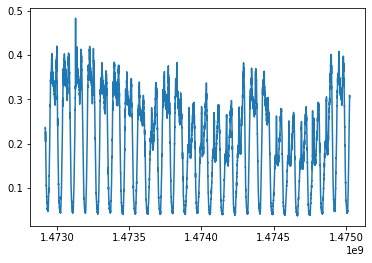

In [103]:
plt.plot(train_data['timestamp'], train_data['value'])
plt.show()

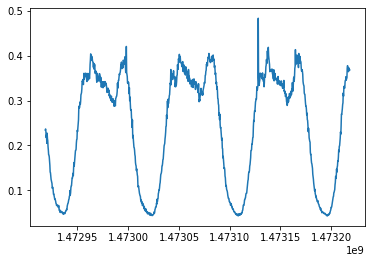

In [104]:
plt.plot(train_data['timestamp'][:1000], train_data['value'][:1000])
plt.show()

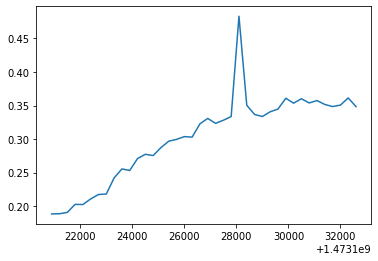

In [105]:
plt.plot(train_data['timestamp'][675:715], train_data['value'][675:715])
plt.show()

In [106]:
# Segment training and testing data appropriately
X_train = train_data.iloc[:, 1:3].to_numpy()
y_train = train_data['ground_truth'].to_numpy()
X_test = test_data.iloc[:, 1:3].to_numpy()
y_test = test_data['ground_truth'].to_numpy()

In [107]:
# Fit the model and evaluate its performance on testing data
knn = KNN()
knn.fit(X_train, y_train)
knn.score(3 * 10**5, X=X_test, y=y_test)

0.5691519635742743

## KNN Evaluation

To evaluate the performance of the KNN classifier on the KPI dataset, both an ROC curve and a PR curve were plotted. The AUC metric for each curve is also shown (for the PR curves, the nearly-equivalent metric of average precision, or AP, is calculated instead). Different plots correspond to KNN models with different $k$-values.

In [158]:
ks = [1, 20, 50, 100]
knns = []
for i in ks:
    knns.append(KNN(n_neighbors=i).fit(X_train, y_train))

probs = []
for i, knn in enumerate(knns):
    probs.append(knn.predict_proba(X=X_test))

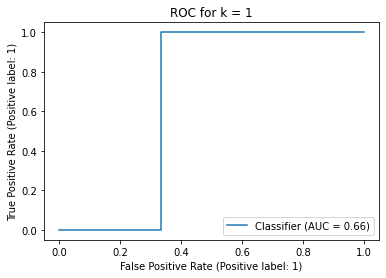

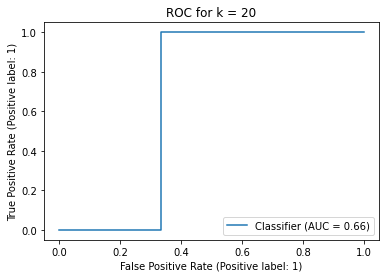

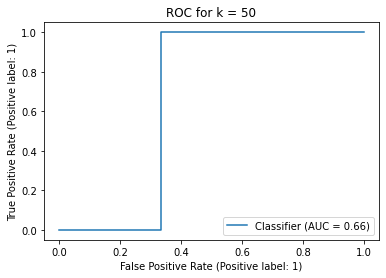

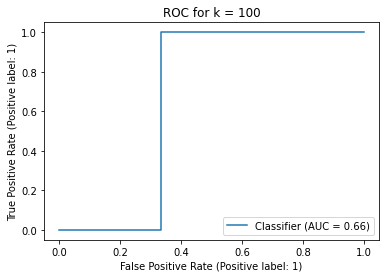

In [159]:
for i, prob in enumerate(probs):
    metrics.RocCurveDisplay.from_predictions(y_test, prob)
    plt.title(f'ROC for k = {ks[i]}')
    plt.show()

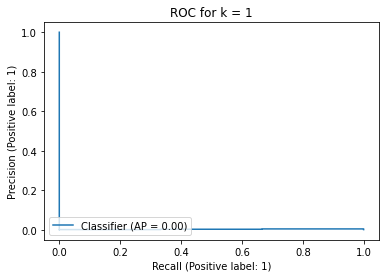

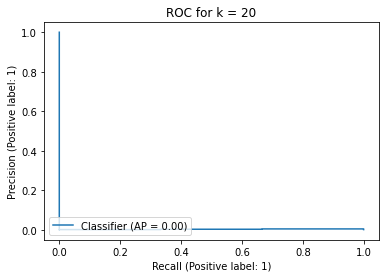

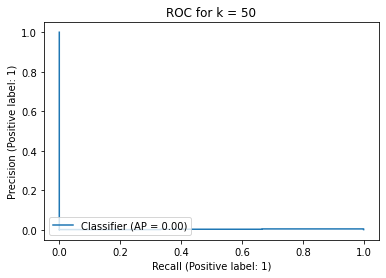

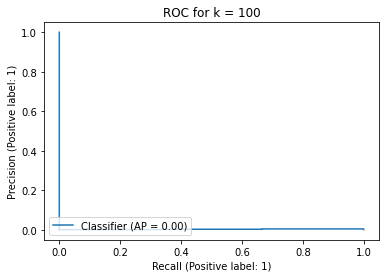

In [160]:
for i, prob in enumerate(probs):
    metrics.PrecisionRecallDisplay.from_predictions(y_test, prob)
    plt.title(f'ROC for k = {ks[i]}')
plt.show()